In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("~/Downloads/brisbane_water_quality.csv",encoding="latin1")
data2 = data.drop(columns = ["Chlorophyll [quality]","Temperature [quality]",
                     "Dissolved Oxygen [quality]","Dissolved Oxygen (%Saturation) [quality]",
                     "pH [quality]","Salinity [quality]","Specific Conductance [quality]",
                     "Turbidity [quality]","Record number"])
data2.tail()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
30889,2024-06-27 08:20:00,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963
30890,2024-06-27 08:30:00,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928
30891,2024-06-27 08:40:00,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097
30892,2024-06-27 08:50:00,10.341,24.711,1.031,18.547,6.740,85.713,8.154,29.247,45.105,4.962
30893,2024-06-27 09:00:00,11.173,241.662,0.946,18.562,5.842,74.326,8.116,29.258,45.121,5.078


In [3]:
data2['Timestamp'] = pd.to_datetime(data2['Timestamp'])

df = data2[data2['Timestamp'] <= '2023-12-01']
df.dropna(subset=["pH","Temperature","Dissolved Oxygen"], inplace=True)

df["Timestamp"]=pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
df["Hour"] = df["Timestamp"].dt.hour
df['Year'] = df["Timestamp"].dt.year
df['Month'] = df["Timestamp"].dt.month
df['Day'] = df["Timestamp"].dt.dayofweek

In [4]:
df = df.sort_values("Timestamp")
df = df.drop_duplicates(subset=["Timestamp"], keep="last")
df = df.set_index("Timestamp").asfreq("30min")
df = df.interpolate()
df = df.reset_index()

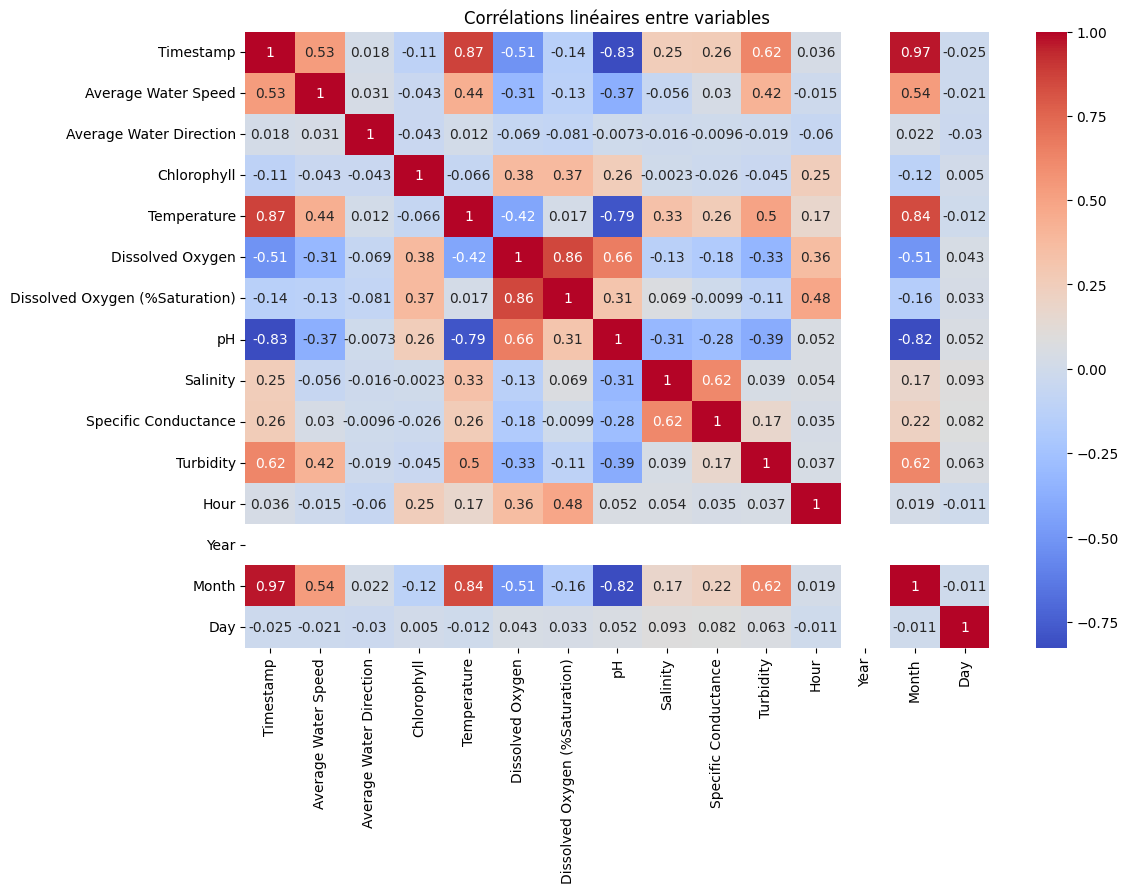

In [5]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')
plt.title("Corrélations linéaires entre variables")
plt.show()

In [6]:
from scipy.stats import spearmanr
num_col = ["Average Water Speed","Temperature","Dissolved Oxygen",
           "Specific Conductance","Turbidity","Salinity","Chlorophyll"]
df_col = df[num_col]

for i in range(len(num_col)):
    coef, p_value = spearmanr(df["pH"],df[num_col[i]])
    print("Coefficient de Spearman sur",num_col[i],":", coef)
    print("p-value sur",num_col[i],":", p_value)

Coefficient de Spearman sur Average Water Speed : -0.41396941211513016
p-value sur Average Water Speed : 1.6009901649804924e-233
Coefficient de Spearman sur Temperature : -0.7908265450249985
p-value sur Temperature : 0.0
Coefficient de Spearman sur Dissolved Oxygen : 0.7091962261666315
p-value sur Dissolved Oxygen : 0.0
Coefficient de Spearman sur Specific Conductance : -0.45661633816131986
p-value sur Specific Conductance : 6.037845828204815e-290
Coefficient de Spearman sur Turbidity : -0.37528855516057774
p-value sur Turbidity : 5.57299368365513e-189
Coefficient de Spearman sur Salinity : -0.3291995865276274
p-value sur Salinity : 2.6729930817363937e-143
Coefficient de Spearman sur Chlorophyll : 0.32615679433286526
p-value sur Chlorophyll : 1.5088643470598332e-140


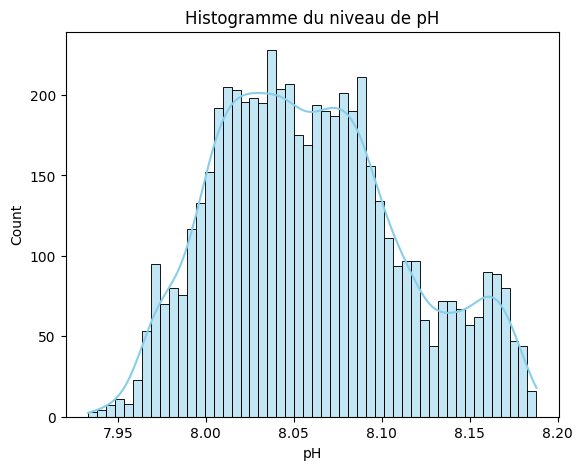

In [7]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['pH'], bins=50, kde=True, color='skyblue')
plt.title("Histogramme du niveau de pH")
plt.show()

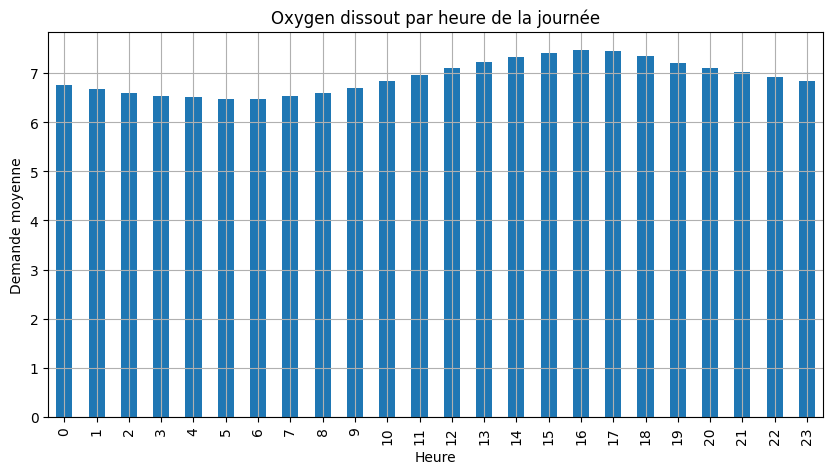

In [8]:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
moyenne_heures = df.groupby('Hour')['Dissolved Oxygen'].mean()

plt.figure(figsize=(10, 5))
moyenne_heures.plot(kind='bar')
plt.title("Oxygen dissout par heure de la journée")
plt.xlabel("Heure")
plt.ylabel("Demande moyenne")
plt.grid(True)
plt.show()

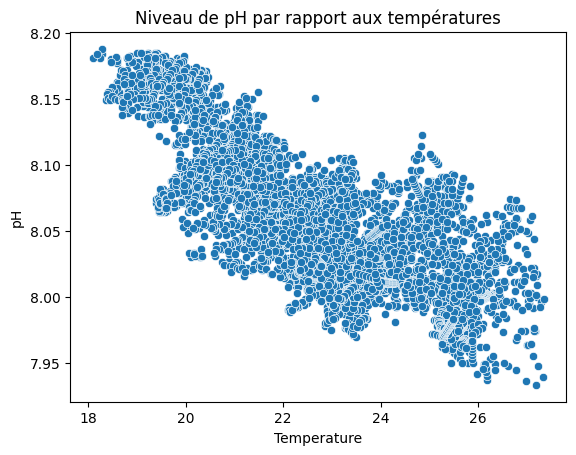

In [9]:
sns.scatterplot(x='Temperature', y='pH', data=df)
plt.title("Niveau de pH par rapport aux températures")
plt.show()

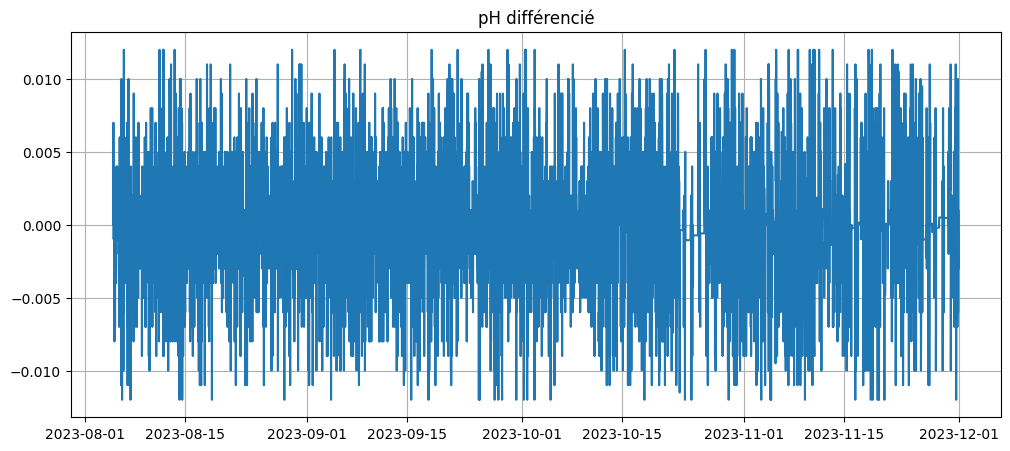

In [10]:
df_diff = df['pH'].diff()
Q1 = df_diff.quantile(0.25) 
Q3 = df_diff.quantile(0.75) 
IQR = Q3 - Q1 
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR 
median = df_diff.median()

df_diff = df_diff.apply(lambda x: median if x < lower or x > upper else x)

plt.figure(figsize=(12, 5))
plt.plot(df['Timestamp'],df_diff, label='Lissé')
plt.title("pH différencié")
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller,kpss

ph = df["pH"].fillna(method="bfill")
ph_diff = ph.diff().dropna()
result = adfuller(ph_diff)
print("ADF Stat:", result[0])
print("p-value:", result[1])

ADF Stat: -22.98014725920392
p-value: 0.0


In [12]:
resultat = kpss(ph_diff)
print(f"La stat du test KPSS pour le pH est : {resultat[0]}")
print(f"La p-value du test KPSS pour le pH est : {resultat[1]}")

La stat du test KPSS pour le pH est : 0.00861708770595996
La p-value du test KPSS pour le pH est : 0.1


C:\Users\yanme\AppData\Local\Temp\ipykernel_6048\3826857179.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultat = kpss(ph_diff)


In [13]:
from statsmodels.tsa.stattools import grangercausalitytests
data3 = df[['pH', 'Temperature']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.6465 , p=0.0000  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=92.0533 , p=0.0000  , df=3
likelihood ratio test: chi2=91.3132 , p=0.0000  , df=3
parameter F test:         F=30.6465 , p=0.0000  , df_denom=5656, df_num=3


{3: ({'ssr_ftest': (30.64651640560441, 1.2050390733207534e-19, 5656.0, 3),
   'ssr_chi2test': (92.05333578762612, 7.933689895880302e-20, 3),
   'lrtest': (91.31317221709469, 1.1441519213043635e-19, 3),
   'params_ftest': (30.646516405742585, 1.2050390730776435e-19, 5656.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [14]:
data3 = df[['pH', 'Dissolved Oxygen']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.5122 , p=0.0000  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=37.5831 , p=0.0000  , df=3
likelihood ratio test: chi2=37.4590 , p=0.0000  , df=3
parameter F test:         F=12.5122 , p=0.0000  , df_denom=5656, df_num=3


{3: ({'ssr_ftest': (12.512226993280704, 3.757219727637339e-08, 5656.0, 3),
   'ssr_chi2test': (37.5831372681835, 3.463284277137658e-08, 3),
   'lrtest': (37.45897395310021, 3.6793138265047596e-08, 3),
   'params_ftest': (12.512226993248746, 3.7572197278133235e-08, 5656.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [15]:
data3 = df[['pH', 'Average Water Speed']].dropna()
grangercausalitytests(data3,maxlag = [3],verbose = True)


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8689  , p=0.1325  , df_denom=5656, df_num=3
ssr based chi2 test:   chi2=5.6138  , p=0.1320  , df=3
likelihood ratio test: chi2=5.6110  , p=0.1321  , df=3
parameter F test:         F=1.8689  , p=0.1325  , df_denom=5656, df_num=3


{3: ({'ssr_ftest': (1.8689481073616907, 0.13251667895658908, 5656.0, 3),
   'ssr_chi2test': (5.613783485850029, 0.13198929867427758, 3),
   'lrtest': (5.611002826008189, 0.1321481227389132, 3),
   'params_ftest': (1.8689481073645917, 0.13251667895606434, 5656.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

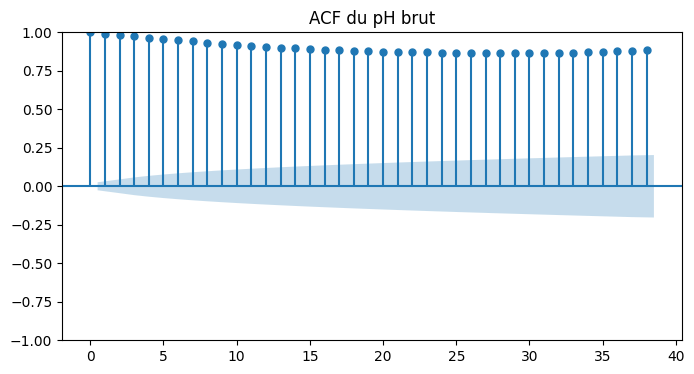

In [16]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sm.graphics.tsa.plot_acf(ph, ax=ax, title="ACF du pH brut")
plt.show()

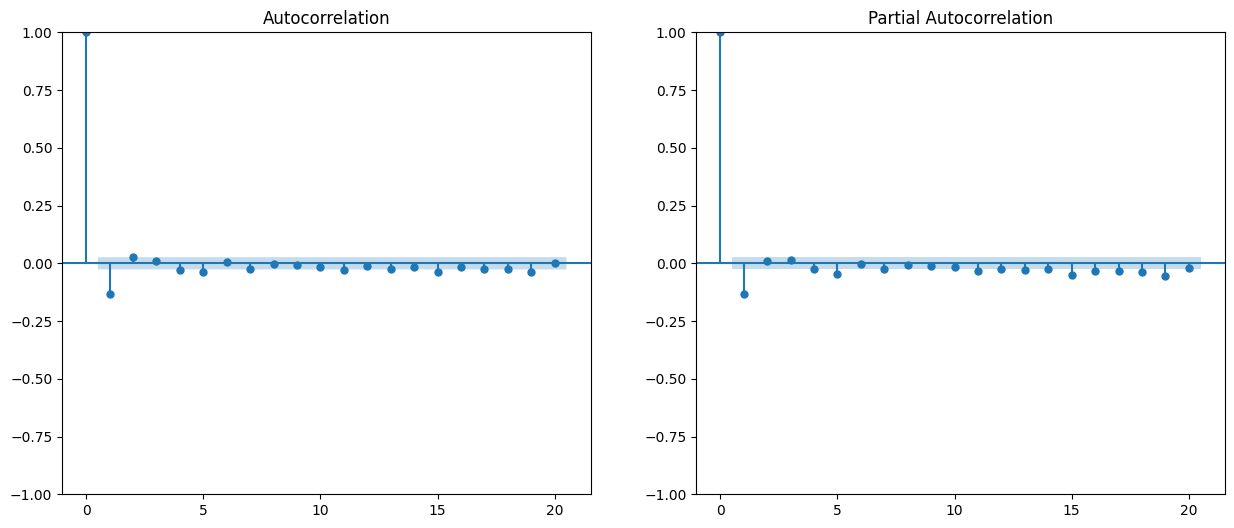

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sm.graphics.tsa.plot_acf(ph_diff, ax=ax1,lags=20)
sm.graphics.tsa.plot_pacf(ph_diff, ax=ax2,lags=20)
plt.show()

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox 

lam,fitted_lambda = boxcox(df["pH"])
lam = pd.Series(lam, index=df.index)
lam = lam.interpolate()
model = ARIMA(lam,order = (2,1,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\yanme\tf_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5666
Model:                 ARIMA(2, 1, 2)   Log Likelihood               64514.037
Date:                Mon, 29 Dec 2025   AIC                        -129018.073
Time:                        21:46:20   BIC                        -128984.863
Sample:                             0   HQIC                       -129006.507
                               - 5666                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -3.449e-10   4.87e-20  -7.09e+09      0.000   -3.45e-10   -3.45e-10
ar.L2       1.724e-15         -0       -inf      0.000    1.72e-15    1.72e-15
ma.L1      -3.448e-10   4.87e-20  -7.09e+09      0.000   -3.45e-10   -3.45e-10
ma.L2      -1.724e-15   3.36e-29  -5.14e+13      0.000   -1.72e-15   -1.72e-15
sigma2      2.034e-11   2.54e-11      0.800      0.424   -2.95e-11    7.02e-11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):        7567082760.25
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            75.25
Prob(H) (two-sided):                  0.00   Kurtosis:                      5663.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

C:\Users\yanme\tf_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


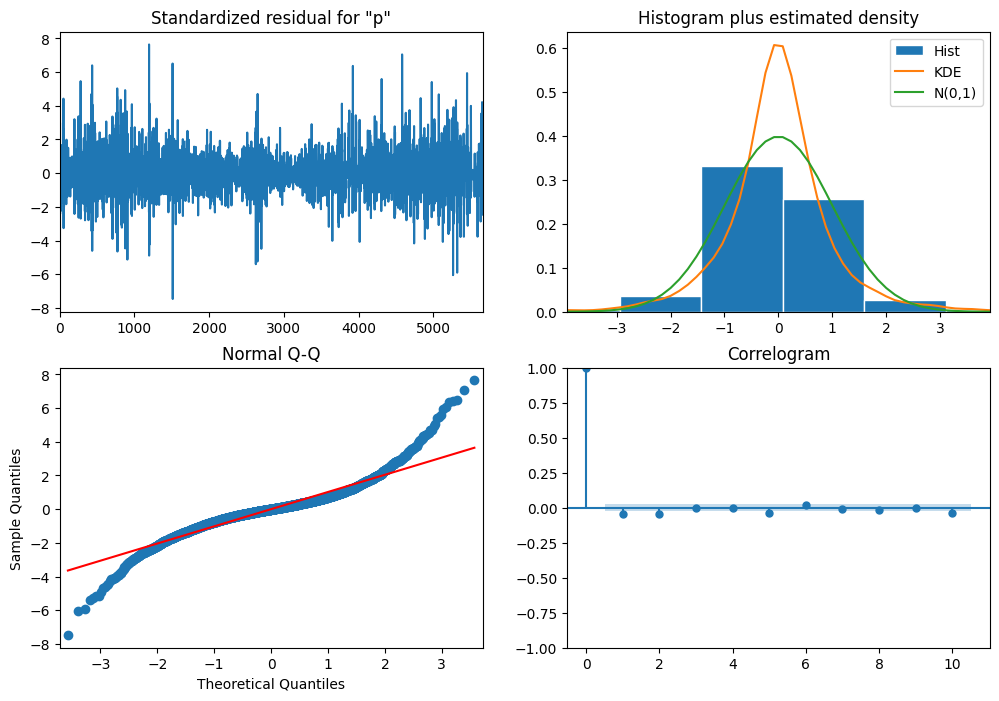

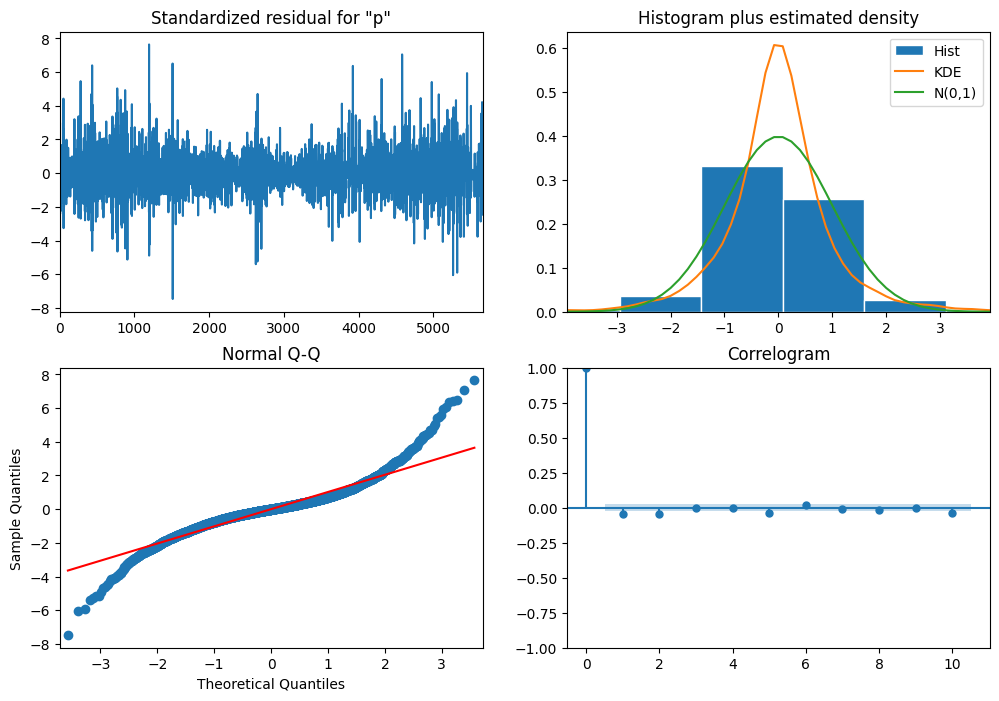

In [19]:
import scipy.stats as stats

residus = pd.DataFrame(model_fit.resid[1:])
residus = residus.squeeze()
residus = residus.interpolate()

model = SARIMAX(df["pH"],exog=df[["Dissolved Oxygen","Temperature"]], order=(2,1,2),seasonal_order = (2,1,2,6))
result = model.fit(disp=False)
result.plot_diagnostics(figsize=(12,8))  

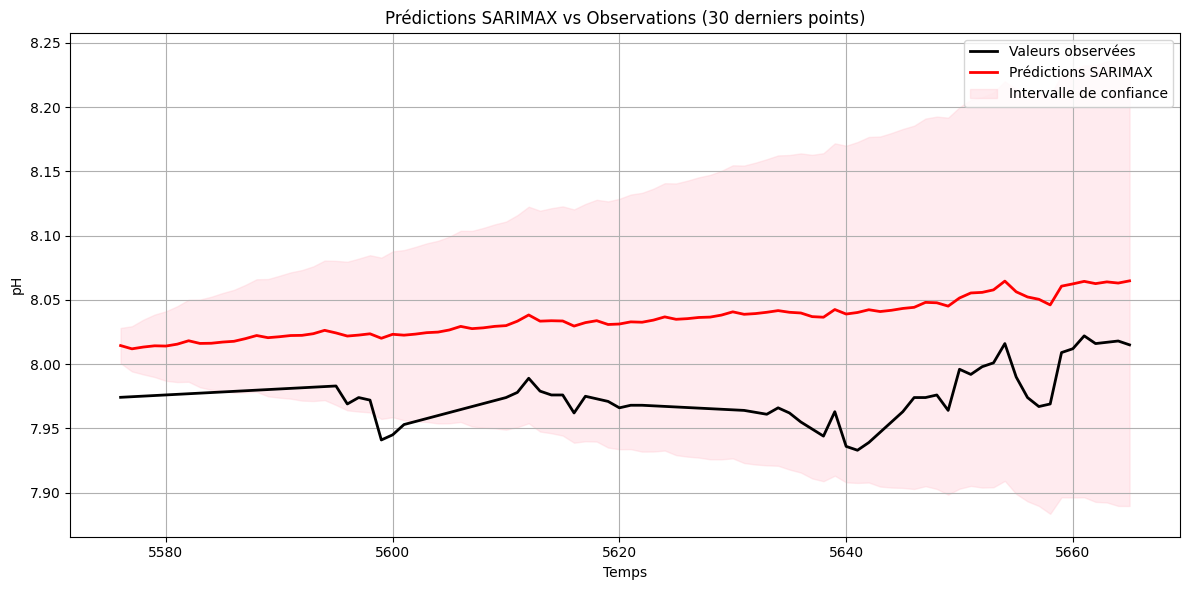

In [21]:
n = 90
train = df.iloc[:-n]
test = df.iloc[-n:]
exog_train = train[["Dissolved Oxygen", "Temperature"]]
exog_test  = test[["Dissolved Oxygen", "Temperature"]]

pred = result.get_forecast(steps=n, exog=exog_test)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(12,6))
plt.plot(test.index, test["pH"],
         label="Valeurs observées", color="black", linewidth=2)
plt.plot(test.index, pred_mean, 
         label="Prédictions SARIMAX", color="red", linewidth=2)

plt.fill_between(test.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],
                 color="pink",alpha=0.3,label="Intervalle de confiance")
plt.title("Prédictions SARIMAX vs Observations (30 derniers points)")
plt.xlabel("Temps")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test["pH"]
y_pred = pred_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAE :", mae)
print("RMSE :", rmse)
print("MAPE :", mape, "%")

MAE : 0.061589114264078905
RMSE : 0.06391470154727469
MAPE : nan %


In [32]:
def create_sequences(df, target, window):
    data = df.copy()
    X, y = [], []
    
    values = data.drop(columns=["Timestamp"]).values
    target_values = data[target].values
    
    for i in range(window, len(df)):
        X.append(values[i-window:i])
        y.append(target_values[i])
    
    return np.array(X), np.array(y)

window = 24
target = "pH"

X, y = create_sequences(df, target, window)

In [33]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[df.columns.drop("Timestamp")] = scaler.fit_transform(df[df.columns.drop("Timestamp")])

X, y = create_sequences(df_scaled, target, window)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0430 - val_loss: 0.0055
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0083 - val_loss: 0.0024
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 9/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 10/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 11/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 12/30
127/127 ━━━━━━━━━━━━━━━━━━━━

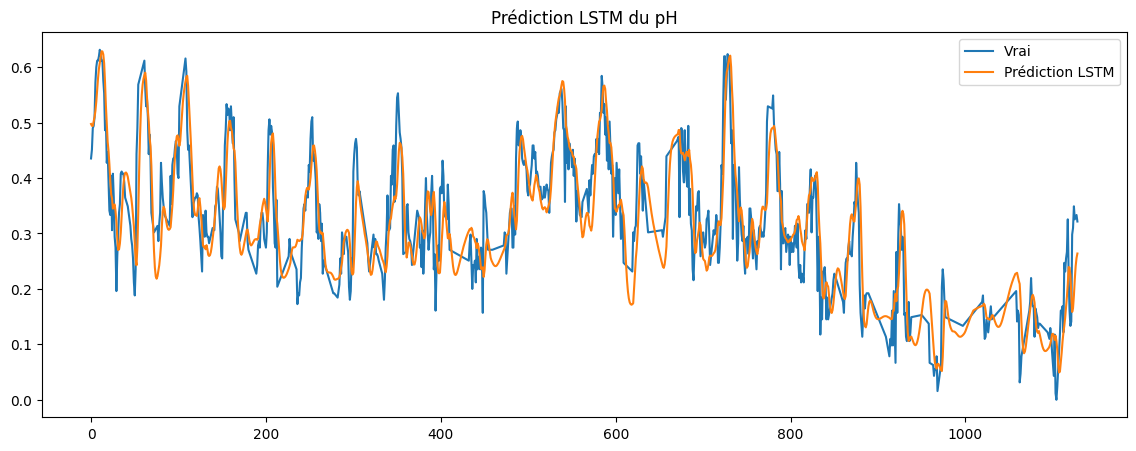

In [36]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE :", rmse)

plt.figure(figsize=(14,5))
plt.plot(y_test, label="Vrai")
plt.plot(y_pred, label="Prédiction LSTM")
plt.legend()
plt.title("Prédiction LSTM du pH")
plt.show()